In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import time
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io as sio
from scipy.misc import *

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
plotly.tools.set_credentials_file(username='ymehta95', api_key='TVHPG5E24omQeUyWougP')
import plotly.plotly as py
import plotly.graph_objs as go

#To install plotpy library:
#pip install plotly --upgrade

In [3]:
file_path='../data'

def __store_data(data, num_of_examples):
    d = []

    for i in range(num_of_examples):
        d.append(data[:, :, :, i])

    return np.asarray(d)


train = sio.loadmat(file_path + "/train_32x32.mat")
y_train = train['y']
train_examples = train['X'].shape[3]
x_train = __store_data(train['X'].astype("float32"), train_examples)
x_train=tf.Session().run(tf.reshape(x_train, [len(x_train),3072]))
x_train=x_train/255

test = sio.loadmat(file_path+"/test_32x32.mat")
y_test = test['y']
test_examples = test['X'].shape[3]
x_test = __store_data(test['X'].astype("float32"), test_examples)
x_test=tf.Session().run(tf.reshape(x_test, [len(x_test),3072]))
x_test=x_test/255

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

(73257, 3072)

In [10]:
y_train=tf.Session().run(tf.one_hot(y_train,depth=10))
y_test=tf.Session().run(tf.one_hot(y_test,depth=10))

y_train=tf.Session().run(tf.reshape(y_train, [len(y_train),10]))
y_test=tf.Session().run(tf.reshape(y_test, [len(y_test),10]))

In [21]:
x=tf.placeholder('float',[None,3072])
y=tf.placeholder('float')

In [34]:
nodes_hl1=1000
nodes_hl2=1000
n_classes=10

In [46]:
def neural_network(data):
    #initializer= tf.contrib.layers.xavier_initializer()
    initializer=tf.keras.initializers.he_normal()
    hl1={'weights':tf.Variable(initializer([3072,nodes_hl1])),'bias':tf.Variable(initializer([nodes_hl1]))}
    hl2={'weights':tf.Variable(initializer([nodes_hl1,nodes_hl2])),'bias':tf.Variable(initializer([nodes_hl2]))}
    output_layer={'weights':tf.Variable(initializer([nodes_hl2,n_classes])),'bias':tf.Variable(initializer([n_classes]))}
    #(input_data*weights +bias)
    #using activation function as ReLU
    l1=tf.add(tf.matmul(data,hl1['weights']),hl1['bias'])
    l1=tf.nn.relu(l1)
                                                                                        
    l2=tf.add(tf.matmul(l1,hl2['weights']),hl2['bias'])
    l2=tf.nn.relu(l2)
                                                                                           
    output=tf.nn.softmax(tf.add(tf.matmul(l2,output_layer['weights']),output_layer['bias']))
                                                                                           
    return output

In [49]:
def train_neural_network(optimizer):
    prediction=neural_network(x)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y))
    
    if optimizer=='adam':
        optimize=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
    if optimizer=='sgd':
        optimize=tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)
        
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(num_epoch):
            for i in range(0, len(x_train), batch_size):
                # Get pair of (X, y) of the current minibatch/chunk
                batch_x = x_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                _, c=sess.run([optimize, cost],feed_dict={x:batch_x,y:batch_y})
                epoch_loss[epoch]+=c
                if i%int((int(len(x_train)/batch_size)/f))==0:
                    correct=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
                    accuracy=tf.reduce_mean(tf.cast(correct,'float'))
                    test_acc.append(accuracy.eval({x:x_test,y:y_test}))
            

            print ('Epoch', epoch+1,'completed out of',num_epoch,'loss:',epoch_loss[epoch])
            print ('Accuracy :', test_acc[-1])
            print (time.time() - start_time, 'sec')

In [50]:
num_epoch=50
f=2 #frequency : number of times in an epoch we want to measure the accuracy
batch_size=128
epoch_loss=np.zeros(num_epoch)
test_acc=[]

if __name__=="__main__":
    start_time=time.time()
    train_neural_network('sgd')
    print ("Training Over. \nNow you are a SuperSaiyan\n")

Epoch 1 completed out of 50 loss: 1164.8658227920532
Accuracy : 0.31042564
8.951647281646729 sec
Epoch 2 completed out of 50 loss: 1113.6885379552841
Accuracy : 0.391134
14.31919264793396 sec
Epoch 3 completed out of 50 loss: 1073.321316242218
Accuracy : 0.42501536
19.86737036705017 sec
Epoch 4 completed out of 50 loss: 1064.6182326078415
Accuracy : 0.43192995
25.185689210891724 sec
Epoch 5 completed out of 50 loss: 1055.4354321956635
Accuracy : 0.4442225
30.558882474899292 sec
Epoch 6 completed out of 50 loss: 1052.2677023410797
Accuracy : 0.43192995
35.905086040496826 sec
Epoch 7 completed out of 50 loss: 1049.5402648448944
Accuracy : 0.44410726
41.26451802253723 sec
Epoch 8 completed out of 50 loss: 1046.700250506401
Accuracy : 0.46001077
46.6319785118103 sec
Epoch 9 completed out of 50 loss: 1045.5894963741302
Accuracy : 0.45939612
52.03828573226929 sec
Epoch 10 completed out of 50 loss: 1044.3083851337433
Accuracy : 0.45175168
57.43001079559326 sec
Epoch 11 completed out of 50 los

In [ ]:
x_axis1=np.arange(num_epoch)
x_axis2= np.arange(0,num_epoch,1/f)

In [ ]:
trace0=go.Scatter(x=x_axis1,y=epoch_loss)
trace1=go.Scatter(x=x_axis2,y=test_acc)
data=([trace0])
py.iplot(data,filename='svhn_adam_loss')

In [ ]:
data=([trace1])
py.iplot(data,filename='svhn_adam_acc')

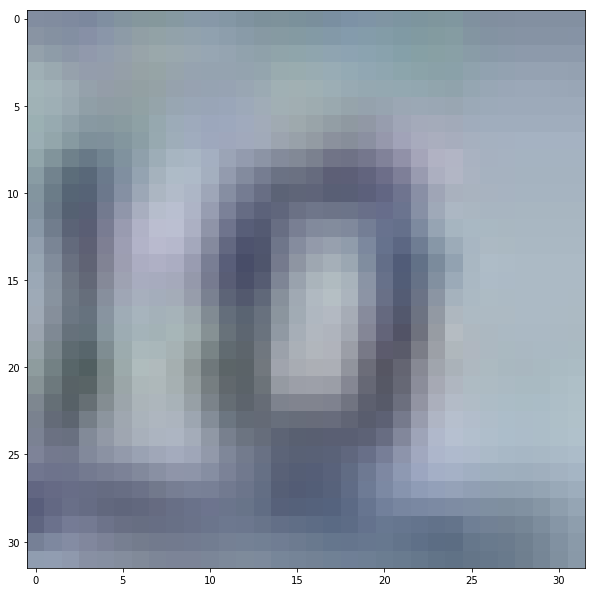

In [66]:
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

img=x_test[3]
img=img/255
plt.figure(figsize=(10,20))
plt.imshow(img)

array([10], dtype=uint8)

In [189]:
num_epoch=15
f=2
epoch_loss=np.zeros(num_epoch)
test_acc=[]

if __name__=="__main__":
    start_time=time.time()
    train_neural_network(x,'adam')
    print ("Training Over. \nNow you are a SuperSaiyan\n")

Epoch 1 completed out of 15 loss: 216050.52932584286
18.33847689628601 sec
Epoch 2 completed out of 15 loss: 54044.441793084145
27.71073293685913 sec
Epoch 3 completed out of 15 loss: 29889.7853683273
38.00689101219177 sec
Epoch 4 completed out of 15 loss: 17047.545924307546
48.064910888671875 sec
Epoch 5 completed out of 15 loss: 10386.48233327642
58.15698003768921 sec
Epoch 6 completed out of 15 loss: 7190.146000626171
67.6778609752655 sec
Epoch 7 completed out of 15 loss: 4956.68605023308
79.25722098350525 sec
Epoch 8 completed out of 15 loss: 3427.2340769574016
91.49116706848145 sec
Epoch 9 completed out of 15 loss: 3507.5167796234164
102.40631008148193 sec
Epoch 10 completed out of 15 loss: 3447.9334479903614
113.9291479587555 sec
Epoch 11 completed out of 15 loss: 2630.8996524894173
125.75755190849304 sec
Epoch 12 completed out of 15 loss: 2793.954569757284
138.2298882007599 sec
Epoch 13 completed out of 15 loss: 2358.9378678427324
149.7964870929718 sec
Epoch 14 completed out of 

In [41]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
plotly.tools.set_credentials_file(username='ymehta95', api_key='TVHPG5E24omQeUyWougP')

In [42]:
x_axis1=np.arange(num_epoch)
x_axis2= np.arange(0,num_epoch,1/f)

In [43]:
trace0=go.Scatter(x=x_axis1,y=epoch_loss)
trace1=go.Scatter(x=x_axis2,y=test_acc)
data=([trace0])
py.iplot(data,filename='svhn_adam_loss')

NameError: name 'go' is not defined

In [192]:
data=([trace1])
py.iplot(data,filename='svhn_adam_acc')

In [226]:
#training with sgd
num_epoch=15
f=2
epoch_loss=np.zeros(num_epoch)
test_acc=[]

if __name__=="__main__":
    start_time=time.time()
    train_neural_network(x,'sgd')
    print ("Training Over. \nNow you are a SuperSaiyan\n")

Epoch 1 completed out of 15 loss: 197529.08947753906
14.626976728439331 sec
Epoch 2 completed out of 15 loss: 70374.04839038849
23.887115716934204 sec
Epoch 3 completed out of 15 loss: 48902.09960216284
32.84867191314697 sec
Epoch 4 completed out of 15 loss: 36237.56115722656
42.171910762786865 sec
Epoch 5 completed out of 15 loss: 28252.46984565258
51.13342785835266 sec
Epoch 6 completed out of 15 loss: 22268.41633850336
59.907628774642944 sec
Epoch 7 completed out of 15 loss: 18130.943677514522
69.3622977733612 sec
Epoch 8 completed out of 15 loss: 14363.760095721027
81.4216639995575 sec
Epoch 9 completed out of 15 loss: 12594.411860768196
92.80380082130432 sec
Epoch 10 completed out of 15 loss: 9646.091426735571
104.54353785514832 sec
Epoch 11 completed out of 15 loss: 8555.11327900162
116.27288484573364 sec
Epoch 12 completed out of 15 loss: 6715.565016703496
125.65238976478577 sec
Epoch 13 completed out of 15 loss: 5586.246938849034
134.91314673423767 sec
Epoch 14 completed out of

In [227]:
trace0=go.Scatter(x=x_axis1,y=epoch_loss)
trace1=go.Scatter(x=x_axis2,y=test_acc)
data=([trace0])
py.iplot(data,filename='mnist_sgd_loss')

In [228]:
data=([trace1])
py.iplot(data,filename='mnist_sgd_acc')